# NNGen Demo — Two Tasks

This notebook showcases two end-to-end capabilities:
- Prompt -> Image: generate a neural-network diagram from natural language.
- Image + Prompt -> Edited Image: modify an existing diagram by instruction (e.g., replace a backbone).

Notes:
- All model calls go through app.llm.gemini.call_gemini. If GEMINI_API_KEY is not set, the pipeline falls back to deterministic local placeholders, so everything runs offline.
- For real image generation/editing, set GEMINI_IMAGE_MODEL / GEMINI_IMAGE_EDIT_MODEL (e.g., gemini-2.5-flash-image or gemini-2.5-flash-image-preview).


In [1]:
# Imports & helpers
from app.graph import run_pipeline, run_fusion_pipeline
from app.state import AppState
from pathlib import Path
from IPython.display import Image, display
import os

def show_image(path: str, width: int = 640):
    p = Path(path)
    if p.exists():
        display(Image(filename=str(p), width=width))
    else:
        print('Not found:', p)

def list_candidates(outdir: str):
    d = Path(outdir)
    paths = sorted([str(p) for p in d.glob('candidate_*.*')])
    if not paths:
        paths = sorted([str(p) for p in d.glob('fused_candidate_*.*')])
    return paths


In [2]:
# Optional: set/echo model environment (dotenv is supported automatically)
# os.environ.setdefault('GEMINI_MODEL', 'gemini-1.5-flash')
# os.environ.setdefault('GEMINI_IMAGE_MODEL', 'gemini-2.5-flash-image')
# os.environ.setdefault('GEMINI_IMAGE_EDIT_MODEL', 'gemini-2.5-flash-image')
print('GEMINI_MODEL:', os.getenv('GEMINI_MODEL', '(default)'))
print('GEMINI_IMAGE_MODEL:', os.getenv('GEMINI_IMAGE_MODEL', '(default)'))
print('GEMINI_IMAGE_EDIT_MODEL:', os.getenv('GEMINI_IMAGE_EDIT_MODEL', '(default)'))


GEMINI_MODEL: gemini-2.5-flash
GEMINI_IMAGE_MODEL: gemini-2.5-flash-image-preview
GEMINI_IMAGE_EDIT_MODEL: gemini-2.5-flash-image-preview


## Task 1 — Prompt -> Image
Describe an architecture in natural language; the multi-agent pipeline plans, prompts, generates candidates, judges them, optionally edits, then archives results (final.png).


Artifacts: artifacts\run_20250907_220825


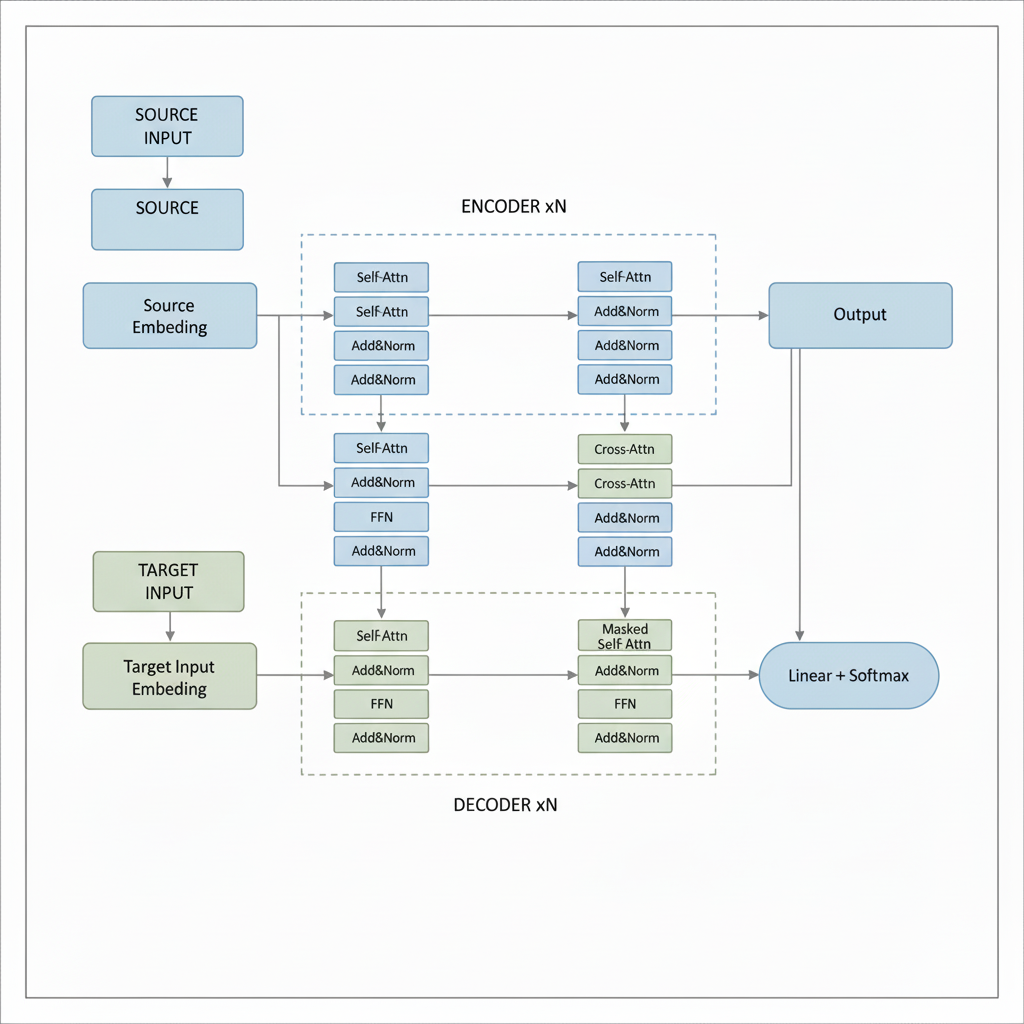

Candidates: ['artifacts\\run_20250907_220825\\candidate_0.png', 'artifacts\\run_20250907_220825\\candidate_0.png.meta.json', 'artifacts\\run_20250907_220825\\candidate_0.resp.txt', 'artifacts\\run_20250907_220825\\candidate_1.png', 'artifacts\\run_20250907_220825\\candidate_1.png.meta.json', 'artifacts\\run_20250907_220825\\candidate_1.resp.txt', 'artifacts\\run_20250907_220825\\candidate_2.png', 'artifacts\\run_20250907_220825\\candidate_2.png.meta.json', 'artifacts\\run_20250907_220825\\candidate_2.resp.txt', 'artifacts\\run_20250907_220825\\candidate_3.png', 'artifacts\\run_20250907_220825\\candidate_3.png.meta.json', 'artifacts\\run_20250907_220825\\candidate_3.resp.txt']


In [3]:
# Use your own prompt or fall back to spec/transformer.txt (ASCII-safe).
try:
    default_text = Path('spec/transformer.txt').read_text(encoding='utf-8')
except Exception:
    default_text = 'Vision Transformer (ViT): 224x224 RGB -> patch embedding (16x16) -> add CLS + positional enc -> Transformer Encoder (L layers: MHA + MLP + residual + LayerNorm) -> CLS -> linear classifier. Layout: left-to-right arrows; correct spelling; readable colors.'
user_text = default_text
K, T = 4, 1
state: AppState = {'K': K, 'T': T, 'user_text': user_text, 'outdir': ''}
final_state = run_pipeline(state)
outdir = final_state['outdir']
print('Artifacts:', outdir)
show_image(str(Path(outdir) / 'final.png'))
cands = list_candidates(outdir)
print('Candidates:', cands)


## Task 2 — Image + Prompt -> Edited Image
Start with an existing diagram image and apply textual instructions to modify the architecture (e.g., replace UNet with Transformer (DiT), keep layout/colors/arrows).


Base image:


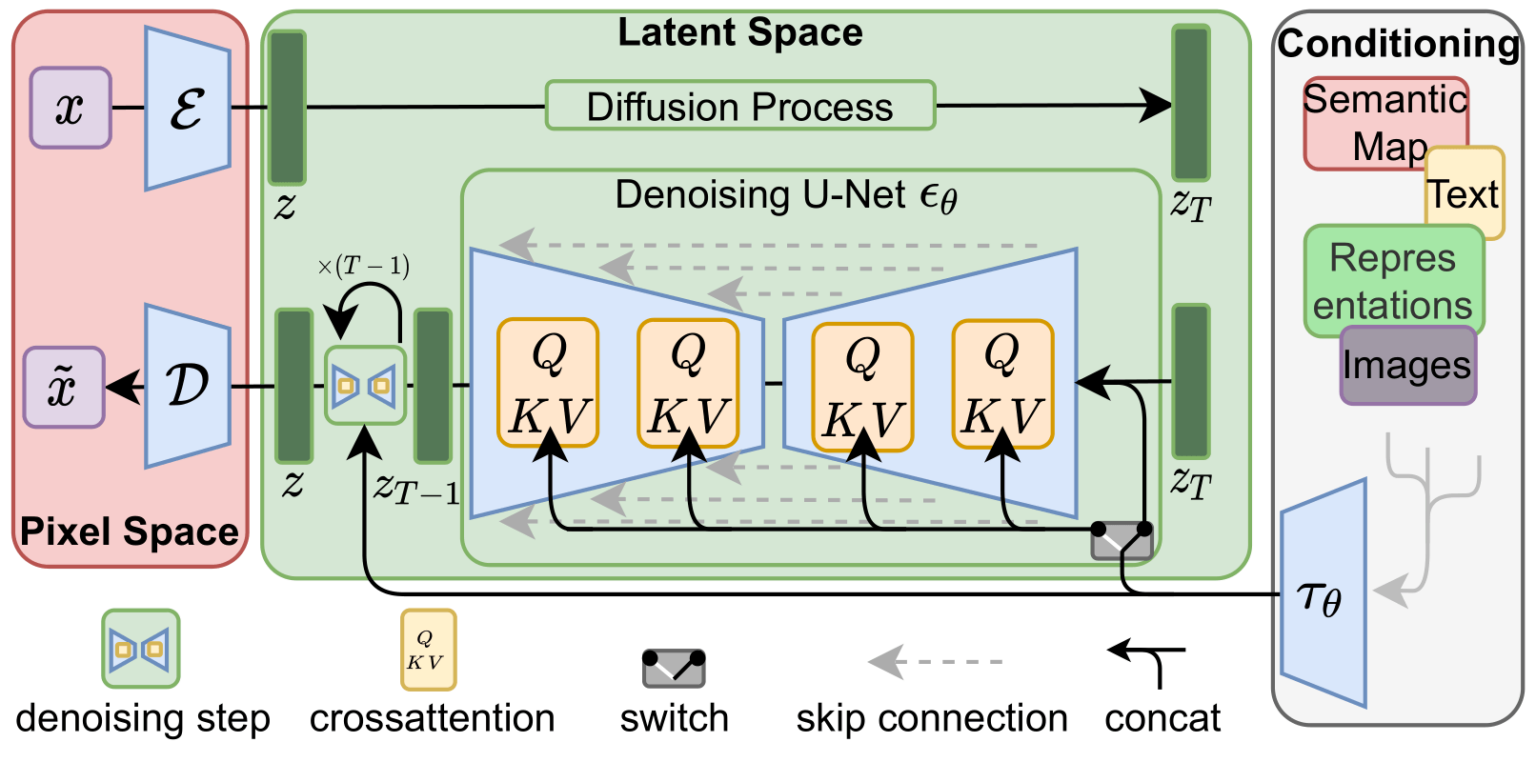

Edited artifacts: artifacts\run_20250907_224157
Edited result:


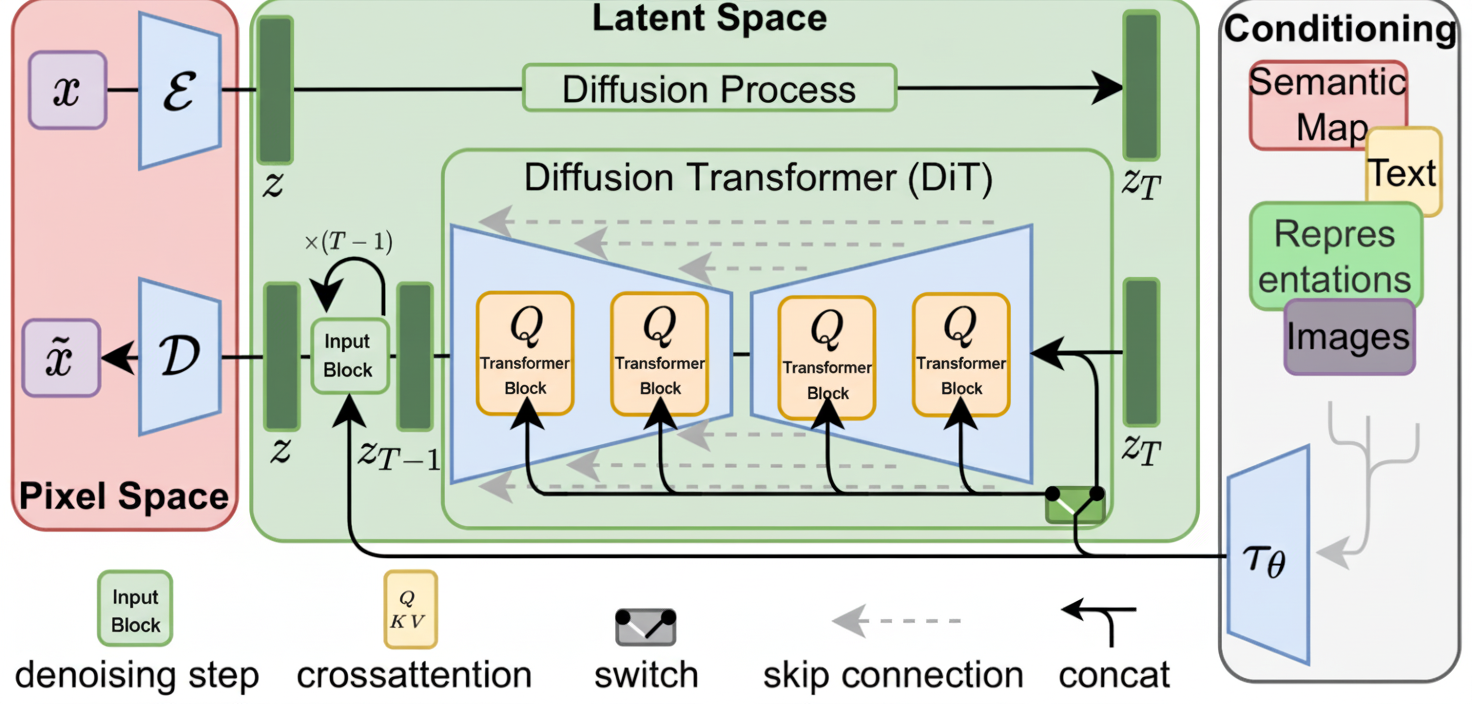

Edited candidates: ['artifacts\\run_20250907_224157\\fused_candidate_0.png', 'artifacts\\run_20250907_224157\\fused_candidate_0.png.meta.json', 'artifacts\\run_20250907_224157\\fused_candidate_0.resp.txt', 'artifacts\\run_20250907_224157\\fused_candidate_1.png', 'artifacts\\run_20250907_224157\\fused_candidate_1.png.meta.json', 'artifacts\\run_20250907_224157\\fused_candidate_1.resp.txt', 'artifacts\\run_20250907_224157\\fused_candidate_2.png', 'artifacts\\run_20250907_224157\\fused_candidate_2.png.meta.json', 'artifacts\\run_20250907_224157\\fused_candidate_2.resp.txt']


In [4]:
# Use a local Stable Diffusion result as the base image (placed under examples/).
base_image = 'examples/StableDiffusion.png'
print('Base image:')
show_image(base_image)
instructions = 'Replace the UNet backbone with a Transformer (DiT)...'
K_edit = 3
state2: AppState = {
    'K': K_edit,
    'T': 0,
    'outdir': '',
    'base_image': base_image,
    'instructions': instructions,
}
final_state2 = run_fusion_pipeline(state2)
outdir2 = final_state2['outdir']
print('Edited artifacts:', outdir2)
print('Edited result:')
show_image(str(Path(outdir2) / 'final.png'))
cands2 = list_candidates(outdir2)
print('Edited candidates:', cands2)
